In [13]:
import numpy as np
import netCDF4 as nc
import scipy.io as sio
from scipy import interpolate
import datetime
import matplotlib.pyplot as plt
import  matplotlib.cm as cm

from seawater import geostrophic
from seawater import eos80

%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/modules/')
import functions_plot

[PrepareTS.ipynb](http://nbviewer.jupyter.org/urls/bitbucket.org/salishsea/tools/raw/tip/I_ForcingFiles/Initial/PrepareTS.ipynb)

# Observations
The salinity and temperature measurements were obtained from M. Chanona. There are 34 profiles. The shallow set has 21 profiles and the deep set has 13 profiles. The shallow set goes to 257 m depth, while the deep goes to 2046 m. In order to look at the data more easily, I joined both sets.

In [14]:
# Load two datasets
ts_data_shal = sio.loadmat('canyonTSdata.mat')
ts_data_deep = sio.loadmat('canyonTSdata2.mat')

# Extract important variables
longitudes = np.concatenate((ts_data_shal['loncanyon'][0], ts_data_deep['loncanyon2'][0]),axis=0)
latitudes = np.concatenate((ts_data_shal['latcanyon'][0], ts_data_deep['latcanyon2'][0]),axis=0)
years = np.concatenate((ts_data_shal['yrcanyon'][0], ts_data_deep['yrcanyon2'][0]),axis=0)
days = np.concatenate((ts_data_shal['daycanyon'][0], ts_data_deep['daycanyon2'][0]),axis=0)
con_temps = np.concatenate((ts_data_shal['tempcanyon'], ts_data_deep['tempcanyon2']),axis=1)
abs_salts = np.concatenate((ts_data_shal['salcanyon'], ts_data_deep['salcanyon2']),axis=1)
depths = np.concatenate((ts_data_shal['depthcanyon'], ts_data_deep['depthcanyon2']),axis=1) * -1

# Dates these measurements were taken
dates = []
for i in range(len(days)):
    date = (datetime.datetime(years[i], 1, 1) + datetime.timedelta(days[i] - 1)).strftime('%b %y')
    dates.append(date)

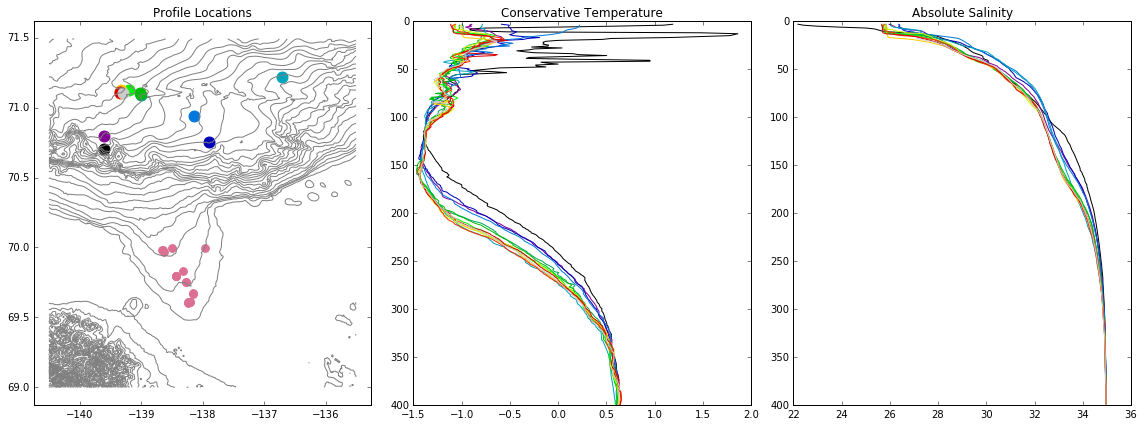

In [15]:
xg, yg, zg = functions_plot.get_variables('G')
xn, yn, zn = functions_plot.def_regionG(-140.5, -135.5, 69.0, 71.5)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,6))
ct = ax1.contour(xn, yn, zn, 60, colors='grey', linestyles='solid')

profiles = np.arange(21,34)
c = cm.nipy_spectral(np.linspace(0, 1, len(profiles)))
for ind, n in zip(profiles, np.arange(len(profiles))):
    ax1.scatter(longitudes[ind], latitudes[ind], color=c[n], s=120)
    ax2.plot(con_temps[:, ind], depths[:, ind], color=c[n])
    ax3.plot(abs_salts[:, ind], depths[:, ind], color=c[n])
    
#ax2.plot(con_temps[:, 21], depths[:, 21], color = 'm')
#ax3.plot(abs_salts[:, 21], depths[:, 21], color = 'm')

profiles = np.arange(21)
for ind in zip(profiles):
    ax1.scatter(longitudes[ind], latitudes[ind], color='palevioletred', s=60)
    
ax2.set_ylim([400,0]); ax3.set_ylim([400,0])
ax1.set_title('Profile Locations')
ax2.set_title('Conservative Temperature')
ax3.set_title('Absolute Salinity')
plt.tight_layout()
plt.show()

# Temperature and Salinity Interpolation Functions

Any extrapolation beyond where there is information will use the last value in the data profile, as specified by the bounds_error and fill_value arguments. The model_bathy is only used to construct the shape of the stratification field. The profiles will not depend on the actual bathymetry.

In [16]:
def interpolate_votemper(interp_ctemp, data_temp, vertical_spacing, model_bathy):
    ''' This function interpolates the conservative temperature to the depths
    specified in the vertical spacing. 
    
    :arg interp_ctemp: interpolation function
    :arg data_temp: conservative temperature data
    :arg vertical_spacing: depth steps 
    :arg model_bathy: domain bathymetry
    '''
    votemper = np.zeros((1, len(vertical_spacing), model_bathy.shape[0], model_bathy.shape[1]))
    votemper[0,0,:,:] = data_temp[0]

    for id in range(1, len(vertical_spacing)):
        for x in range(0, model_bathy.shape[1]):
            for y in range(0, model_bathy.shape[0]):
                votemper[0, id, y, x] = interp_ctemp(vertical_spacing[id])
    return votemper

def interpolate_vosaline(interp_asalt, data_salt, vertical_spacing, model_bathy):
    ''' This function interpolates the absolute salinity to the depths
    specified in the vertical spacing. 
    
    :arg interp_asalt: interpolation function
    :arg data_salt: absolute salinity data
    :arg vertical_spacing: depth steps 
    :arg model_bathy: domain bathymetry
    '''
    vosaline = np.zeros((1, len(vertical_spacing), model_bathy.shape[0], model_bathy.shape[1]))
    vosaline[0,0,:,:] = data_salt[0]

    for id in range(1, len(vertical_spacing)):
        for x in range(0, model_bathy.shape[1]):
            for y in range(0, model_bathy.shape[0]):
                vosaline[0, id, y, x] = interp_asalt(vertical_spacing[id])
    return vosaline

The profile number is specified and the corresponding depth, temperature, and salinity profiles are extracted and used in calling the interpolation functions. The nans are excluded from the profiles by cutting the profile at the last non-nan depth. Then, when the interpolation functions are called, the fill_value used to extend the stratification profile to the desired depth is defined as the last non-nan depth. Additionally, the interp1d function requires all values to be real. However, sometimes there will be nans at the surface. The full_nans function takes care of this by linearly interpolating with the neighbouring value. This had to be done because the interp1d fill_value only applies to regions out of the range of depths. 

In [17]:
def fill_nans(data):
    mask = np.isnan(data)
    data[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), data[~mask])
    return data

In [18]:
def prepare_profile(profile_number, depths, con_temps, abs_salts):
   
    full_depth = depths[:, profile_number]
    ind_end = np.where(full_depth == np.nanmax(full_depth))[0][0]
    prof_depth = full_depth[:ind_end+1]

    full_ctemp = con_temps[:, profile_number]
    prof_ctemp = full_ctemp[:ind_end+1]

    full_asalt = abs_salts[:, profile_number]
    prof_asalt = full_asalt[:ind_end+1]
    
    prof_depth = fill_nans(prof_depth)
    prof_ctemp = fill_nans(prof_ctemp)
    prof_asalt = fill_nans(prof_asalt)
    
    return prof_depth, prof_ctemp, prof_asalt

In [19]:
def prepare_interpolation(prof_depth, prof_ctemp, prof_asalt):

    interp_ctemp = interpolate.interp1d(prof_depth, prof_ctemp, kind='cubic', 
                                    bounds_error=False, fill_value=prof_ctemp[-1], assume_sorted=False)
    interp_asalt = interpolate.interp1d(prof_depth, prof_asalt, kind='cubic', 
                                    bounds_error=False, fill_value=prof_asalt[-1], assume_sorted=False)
    
    return interp_ctemp, interp_asalt

In [20]:
def generate_interpolation(interp_ctemp, interp_asalt, prof_ctemp, prof_asalt, vertical_spacing, model_bathy):
    
    strat_votemper = interpolate_votemper(interp_ctemp, prof_ctemp, vertical_spacing, model_bathy)
    strat_vosaline = interpolate_vosaline(interp_asalt, prof_asalt, vertical_spacing, model_bathy)
    
    return strat_votemper, strat_vosaline

In [21]:
def full_stratification(profile_number, depths, con_temps, abs_salts):
    
    prof_depth, prof_ctemp, prof_asalt = prepare_profile(profile_number, depths, con_temps, abs_salts)
    interp_ctemp, interp_asalt = prepare_interpolation(prof_depth, prof_ctemp, prof_asalt)
    strat_votemper, strat_vosaline = generate_interpolation(interp_ctemp, interp_asalt, prof_ctemp, prof_asalt, 
                                                            vertical_spacing, model_bathy)
    
    return strat_votemper, strat_vosaline, prof_depth, prof_ctemp, prof_asalt

In [22]:
def plot_interpolations(strat_votemper, strat_vosaline, prof_depth, prof_ctemp, prof_asalt,
                        vertical_spacing, model_bathy):

    xs, ys = 58, 58; c = 'dodgerblue'
    fig, (ax2, ax3, ax4) = plt.subplots(1,3,figsize=(14,6)); fig.tight_layout()

    ax2.plot(vertical_spacing, c = 'forestgreen', lw = 2, marker = 'o', linestyle = '-')
    ax2.set_title('depths ' + str(vertical_spacing.shape))
    ax2.set_ylim(prof_depth[-1], 0)

    ax3.plot(prof_ctemp, prof_depth, c = 'gray', lw=2, marker ='o', linestyle='-', label='data', alpha=0.4)
    ax3.plot(strat_votemper[0, :, ys, xs], vertical_spacing, c=c, lw=2, marker ='o', linestyle='-', label='interp')
    ax3.set_title('temperature ' + str(prof_ctemp.shape) + ' ' + str(strat_votemper.shape))
    ax3.legend(loc=4); ax3.set_ylim(prof_depth[-1], 0)

    ax4.plot(prof_asalt, prof_depth, c = 'gray', lw=2, marker ='o', linestyle='-', label='data', alpha=0.4)
    ax4.plot(strat_vosaline[0, :, ys, xs], vertical_spacing, c=c, lw=2, marker ='o', linestyle='-', label='interp')
    ax4.set_title('salinity ' + str(prof_asalt.shape) + ' ' + str(strat_vosaline.shape))
    ax4.legend(loc=3); ax4.set_ylim(prof_depth[-1], 0)

    plt.show()

    return fig

# Creating Individual Profile

The mesh mask is loaded to obtain the depth profile calculated by nemo, as opposed to deriving it from its analytical formulation. The bathymetry file is used strictly to obtain the shape of the domain in use. The files salinity_01.nc and temperature_01.nc used profile 21.

In [23]:
path_bath = 'idealized/ideal_bathy_03.nc'
path_mesh = 'runs_idealized/Run01/mesh_mask.nc'

file_bath = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/initial_sets/' + path_bath)
file_mesh = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/gyre_mackenzie02/EXP00/' + path_mesh)

model_bathy = file_bath['Bathymetry'][:]
vertical_spacing = file_mesh['gdept_1d'][:][0]

In [24]:
profile_number = 21
strat_votemper, strat_vosaline, prof_depth, prof_ctemp, prof_asalt = full_stratification(profile_number, 
                                                                                         depths, con_temps, abs_salts)

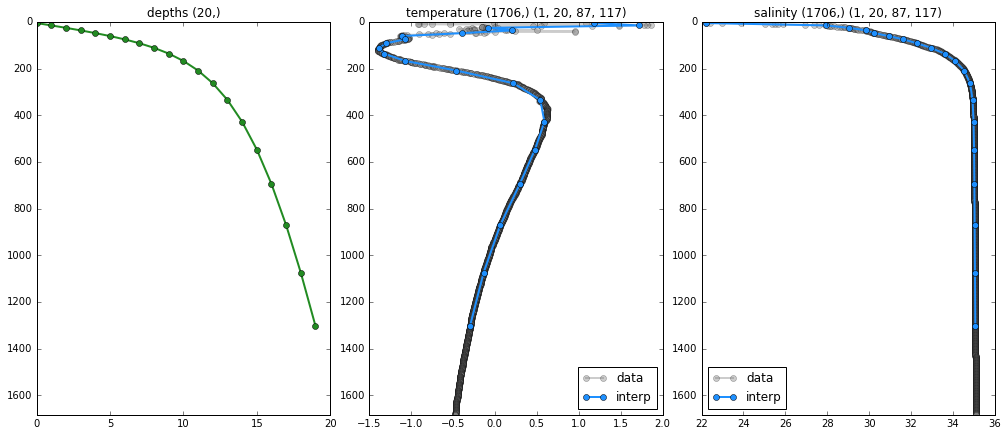

In [25]:
fig = plot_interpolations(strat_votemper, strat_vosaline, prof_depth, prof_ctemp, prof_asalt,
                        vertical_spacing, model_bathy)

# Creating Stratification File

# Creating All Profiles

In [26]:
profiles = np.arange(0,34)
indices = np.arange(len(profiles))

all_votempers = np.zeros([vertical_spacing.shape[0], len(profiles)])
all_vosalines = np.zeros([vertical_spacing.shape[0], len(profiles)])

for profile_number, ind in zip(profiles, indices):
    strat_votemper, strat_vosaline, prof_depth, prof_ctemp, prof_asalt = full_stratification(profile_number, 
                                                                                         depths, con_temps, abs_salts)
    all_votempers[:,ind] = strat_votemper[0,:,58,58]
    all_vosalines[:,ind] = strat_vosaline[0,:,58,58]

In [49]:
np.arange(21,34).shape

(13,)

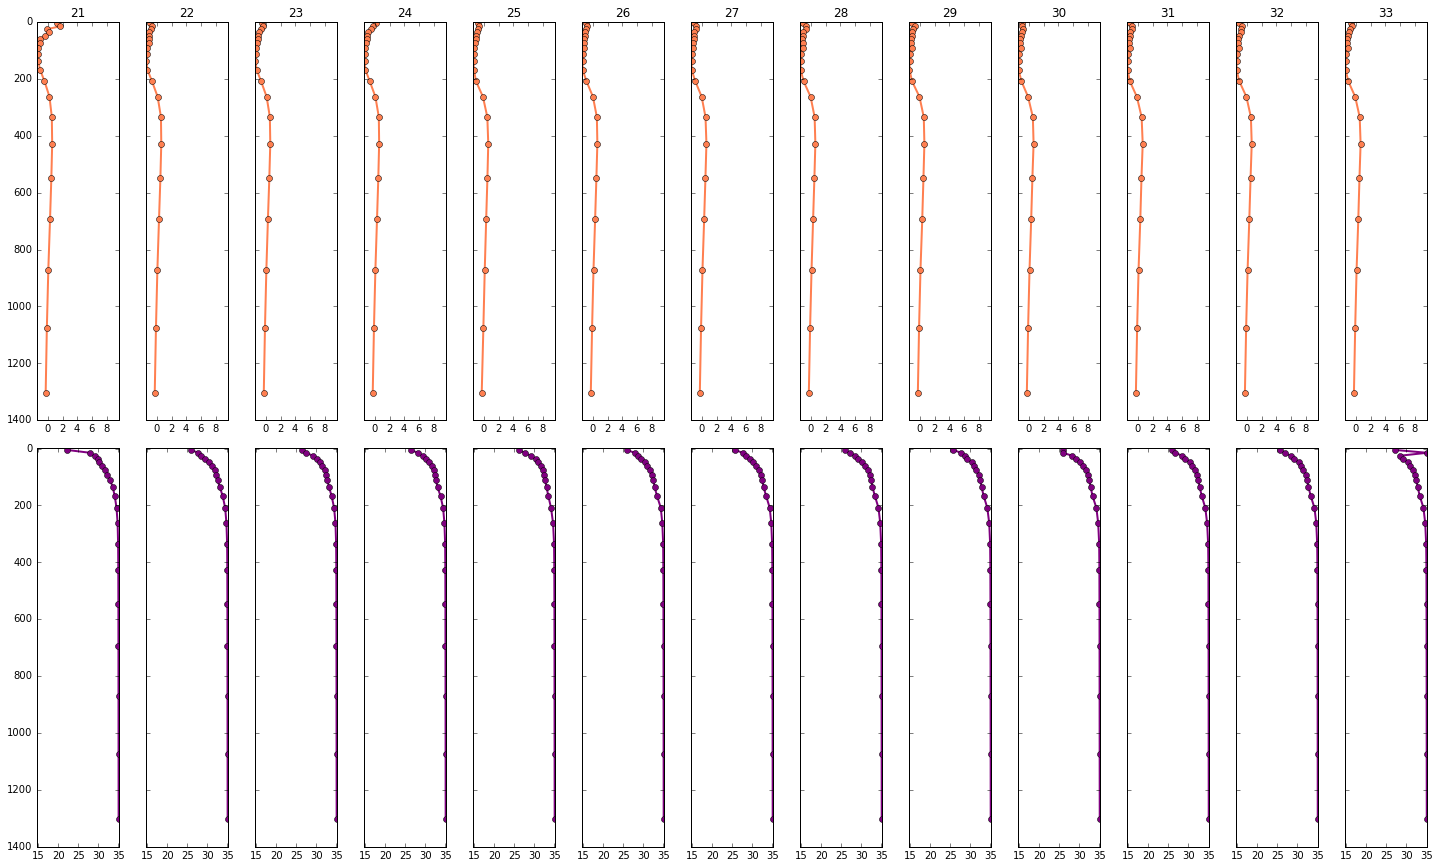

In [55]:
fig, axes = plt.subplots(2, 13, figsize=(20,12), sharey=True)
fig.tight_layout()
profiles = np.arange(21,34)
indices = np.arange(len(profiles))
for profile_number, ind in zip(profiles, indices):
    axes[0, ind].plot(all_votempers[:, profile_number], vertical_spacing, c='coral', lw=2, marker ='o', linestyle='-')
    axes[1, ind].plot(all_vosalines[:, profile_number], vertical_spacing, c='purple', lw=2, marker ='o', linestyle='-')
    axes[0, ind].invert_yaxis()
    axes[0, ind].set_xlim(round(all_votempers.min(), 2), round(all_votempers.max(), 2))
    axes[0, ind].set_title(str(profiles[ind]))
    axes[1, ind].set_xlim(round(all_vosalines.min(), 2), round(all_vosalines.max(), 2))

# Calculating N

KRM (~Barkley): 
* N = 5.5 x 10$^{-3}$
* B ~ 1 or 2
* H$_s$ ~ 150 m 
* L = 6400 m, W$_{sb}$ = 13000 m, R = 5000 m

Mackenzie: 
* L = 93744.3331621 m 

[SelectRunsUsingRestrictionsAH2010.ipynb](http://nbviewer.jupyter.org/urls/bitbucket.org/canyonsubc/outputanalysisnotebooks/raw/tip/scaling/SelectRunsUsingRestrictionsAH2010.ipynb)

In [36]:
all_Ns = np.zeros([vertical_spacing.shape[0]-1, len(profiles)])

for profile_number, ind in zip(profiles, indices):
    pressure = eos80.pres(vertical_spacing, latitudes[profile_number])
    n2, q, p_ave = geostrophic.bfrq(all_vosalines[:, profile_number], all_votempers[:, profile_number], pressure, lat=None)
    N = np.sqrt(n2)
    all_Ns[:,ind] = N[:,0]

all_Ns[:,21]

array([ 0.06551125,  0.02985398,  0.02356211,  0.0166039 ,  0.02066691,
        0.01945839,  0.01733183,  0.01614612,  0.01418625,  0.01092645,
        0.00860005,  0.00565828,  0.00313386,  0.00185826,  0.00150212,
        0.00129765,  0.00125372,  0.00115848,  0.00107106])

In [44]:
from salishsea_tools import teos_tools

all_Ns = np.zeros([vertical_spacing.shape[0]-1, len(profiles)])
all_vosalines_psu = np.zeros_like(all_vosalines)

for profile_number, ind in zip(profiles, indices):
    pressure = eos80.pres(vertical_spacing, latitudes[profile_number])
    all_vosalines_psu[:,ind] = teos_tools.teos_psu(all_vosalines[:,ind])
    n2, q, p_ave = geostrophic.bfrq(all_vosalines_psu[:, profile_number], all_votempers[:, profile_number], pressure)
    N = np.sqrt(n2)
    all_Ns[:,ind] = N[:,0]
    
all_Ns[:,21]

array([ 0.06536037,  0.02977923,  0.0235091 ,  0.01656144,  0.02061484,
        0.01941368,  0.01729053,  0.01610838,  0.01415376,  0.01090244,
        0.00858262,  0.00564766,  0.00312781,  0.0018541 ,  0.00149814,
        0.00129397,  0.00125012,  0.00115528,  0.0010682 ])

In [63]:
from salishsea_tools import gsw_calls

CT = gsw_calls._call_CT_from_PT(all_vosalines[:,21], all_votempers[:,21])

FileNotFoundError: [Errno 2] No such file or directory: 'CTout'


Undefined function 'mw_gsw_CT_from_pt' for input arguments of type 'char'.